In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Training RNN Model...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 123s 213ms/step - accuracy: 0.5037 - loss: 0.7032 - val_accuracy: 0.5264 - val_loss: 0.6918
Epoch 2/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 122s 217ms/step - accuracy: 0.5250 - loss: 0.6908 - val_accuracy: 0.5771 - val_loss: 0.6760
Epoch 3/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 140s 215ms/step - accuracy: 0.5579 - loss: 0.6794 - val_accuracy: 0.5318 - val_loss: 0.6752
Epoch 4/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 143s 218ms/step - accuracy: 0.5726 - loss: 0.6693 - val_accuracy: 0.7891 - val_loss: 0.4848
Epoch 5/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 139s 213ms/step - accuracy: 0.8148 - loss: 0.4606 - val_accuracy: 0.6305 - val_loss: 1.1041
Epoch 6/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 145s 218ms/step - accuracy: 0.7015 - loss: 0.6050 - val_accuracy: 0.4739 - val_loss: 0.6952
Epoch 7/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 139s 212ms/step - accuracy: 0.5423 - loss: 0.6858 - val_accuracy: 0.5955 - val_loss: 0.6475
Epoch 8/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 142s 213ms/step - accuracy: 0.5828 - loss: 0.65

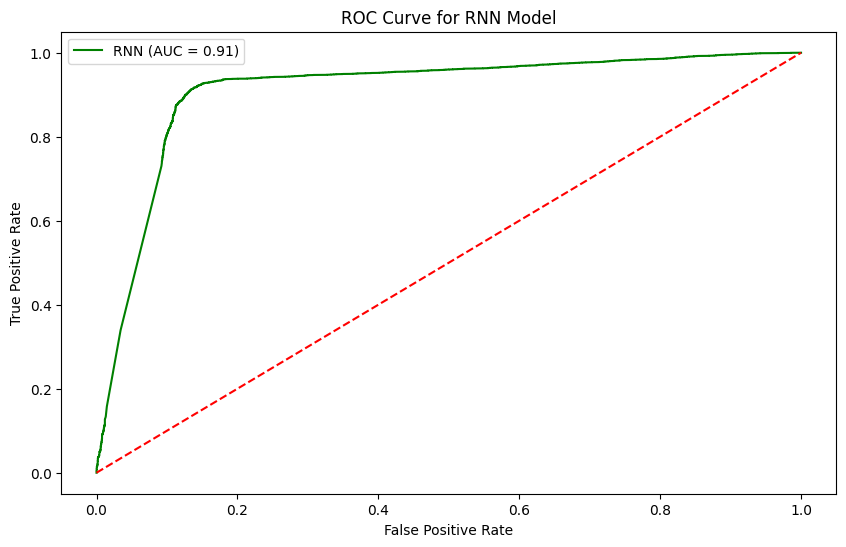

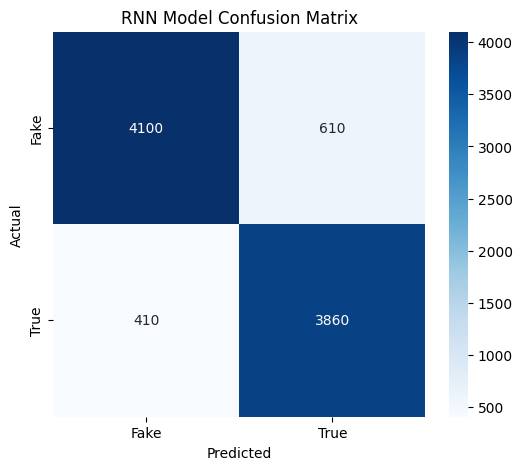

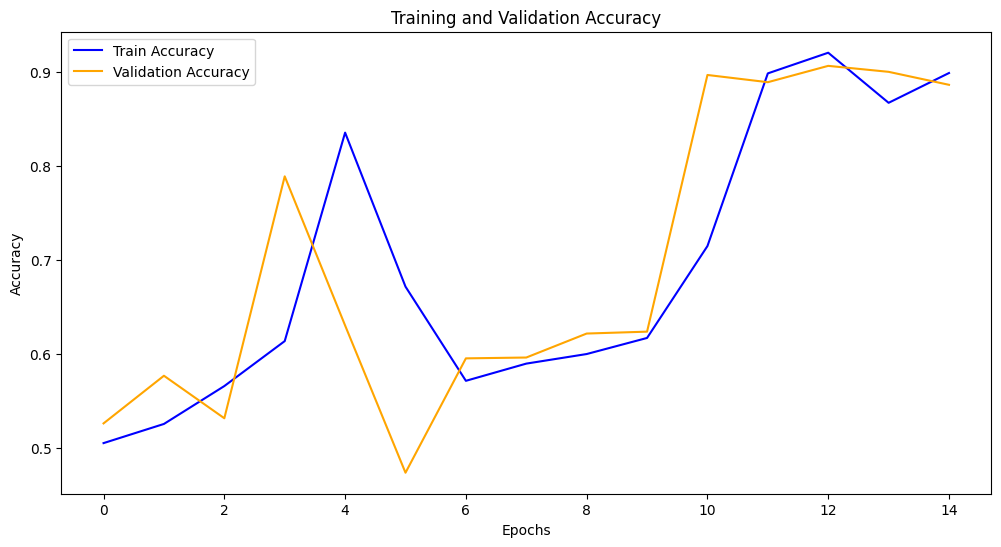

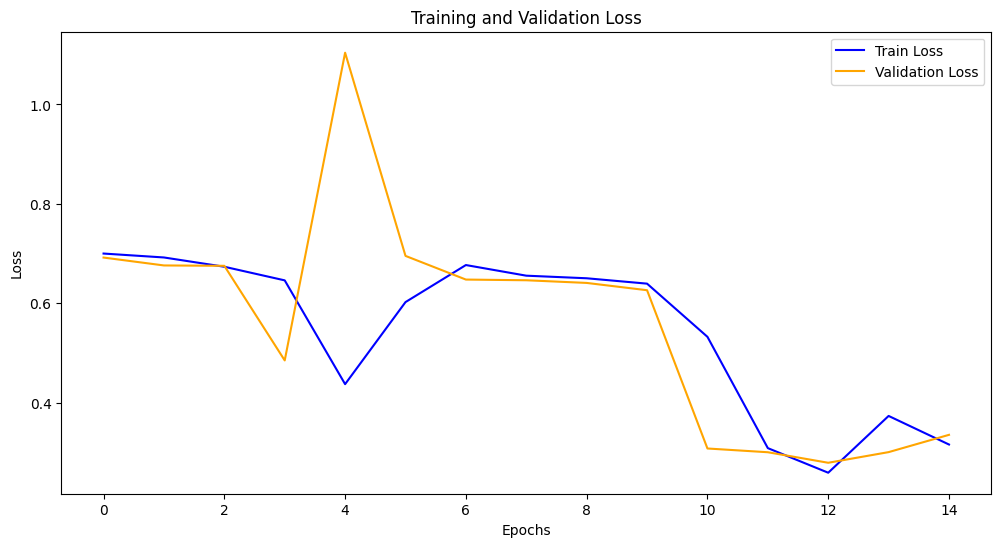

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Add labels: 0 for fake, 1 for true
fake_df['label'] = 0
true_df['label'] = 1

# Combine datasets
data = pd.concat([fake_df, true_df], ignore_index=True)
data = data[['text', 'label']]

# Shuffle the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Prepare inputs (text) and outputs (labels)
X = data['text']
y = data['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=500, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=500, padding='post', truncating='post')

# Build the RNN model using SimpleRNN
rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=500),  # Embedding Layer
    SimpleRNN(64, return_sequences=False),  # SimpleRNN Layer with 64 units
    Dropout(0.5),  # Dropout Layer to prevent overfitting
    Dense(64, activation='relu'),  # Fully connected Dense Layer
    Dropout(0.5),  # Dropout Layer
    Dense(1, activation='sigmoid')  # Output Layer with sigmoid activation for binary classification
])

# Compile the model
# Loss function: Binary Crossentropy (for binary classification)
# Optimizer: Adam (Adaptive Moment Estimation for better optimization)
# Metrics: Accuracy
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("Training RNN Model...")
rnn_history = rnn_model.fit(X_train_padded, y_train,
                            epochs=15,  # Increased epochs to 15
                            batch_size=64,
                            validation_data=(X_test_padded, y_test))

# Evaluate the model
y_pred_rnn = rnn_model.predict(X_test_padded).ravel()
y_pred_rnn_class = (y_pred_rnn > 0.5).astype(int)

# Performance metrics
print("\nRNN Model Performance:")
print(classification_report(y_test, y_pred_rnn_class))

# Plot ROC Curve and AUC
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, y_pred_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rnn, tpr_rnn, label=f'RNN (AUC = {roc_auc_rnn:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RNN Model')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rnn_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title(f'RNN Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optional: Plot Training and Validation Accuracy/Loss over Epochs
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['loss'], label='Train Loss', color='blue')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()